In [1]:
'''
import kagglehub
#Download latest version
path = kagglehub.dataset_download("wwymak/architecture-dataset")
print("Path to dataset files:", path)
'''

'\nimport kagglehub\n#Download latest version\npath = kagglehub.dataset_download("wwymak/architecture-dataset")\nprint("Path to dataset files:", path)\n'

In [2]:
import os
import time
import torch
import timm
import random
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch import amp
from tqdm import tqdm
from timm.data import Mixup
from timm.scheduler import CosineLRScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score
import numpy as np

# ============================================================
# CONFIG
# ============================================================

DATASET_PATH = "/workspace/Data/arcDataset_split"
MODEL_SAVE_PATH = "/workspace/Notebooks/best_ResNet-RS_model.pth"
FULL_MODEL_SAVE_PATH = "/workspace/Notebooks/best_ResNet-RS_full.pth"

EARLY_STOP_PATIENCE = 7
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_CLASSES = 25
EPOCHS = 50
LR = 3e-4 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    print(f"Torch CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3070
Torch CUDA version: 12.1


In [3]:
# ============================================================
# DATASET + TRANSFORMS
# ============================================================

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_tf)
val_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "val"), transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [4]:
# ============================================================
# MODEL + LOSS + OPTIMIZER + MIXUP
# ============================================================

model = timm.create_model(
    "resnetrs50",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scaler = amp.GradScaler(device="cuda")

mixup_fn = Mixup(
    mixup_alpha=0.2,
    cutmix_alpha=0.4,
    label_smoothing=0.0,
    num_classes=NUM_CLASSES
)

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=EPOCHS,
    warmup_t=5,
    warmup_lr_init=1e-6,
    lr_min=1e-6,
)

model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

In [5]:
# ============================================================
# VALIDATION FUNCTION
# ============================================================
def validate():
    model.eval()
    total, correct, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            loss_total += loss.item()
            _, predicted = preds.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)
    return correct / total, loss_total / len(val_loader)

In [6]:
# ============================================================
# TRAINING LOOP
# ============================================================
best_acc = 0.0
epochs_no_improve = 0
train_losses, val_losses, val_accs = [], [], []

print("Entrenando ResNet-RS...\n")
start_total = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)
    for x, y in loop:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        # Aplicar Mixup/CutMix
        x_mix, y_mix = mixup_fn(x, y)

        with amp.autocast("cuda"):
            preds = model(x_mix)
            loss = criterion(preds, y_mix)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    val_acc, val_loss = validate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_acc': best_acc,
        }, MODEL_SAVE_PATH)

        # Guardar un modelo completo para inferencia
        torch.save(model, FULL_MODEL_SAVE_PATH)

        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Scheduler step
    scheduler.step(epoch)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Epoch Time: {time.time()-epoch_start:.1f}s")

    # Early stopping
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping activado. No hubo mejora en {EARLY_STOP_PATIENCE} epochs.")
        break

total_time = (time.time() - start_total) / 60
print(f"\nTiempo total de entrenamiento: {total_time:.2f} minutos")

Entrenando ResNet-RS...



Epoch 1/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.17it/s, loss=3.25]


Epoch 1/50 | Train Loss: 3.2506 | Val Acc: 0.0258 | Val Loss: 3.2455 | Epoch Time: 20.9s


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.26it/s, loss=3.2]


Epoch 2/50 | Train Loss: 3.2314 | Val Acc: 0.0351 | Val Loss: 3.2275 | Epoch Time: 20.1s


Epoch 3/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.32it/s, loss=1.88]


Epoch 3/50 | Train Loss: 2.7069 | Val Acc: 0.5150 | Val Loss: 1.9381 | Epoch Time: 20.3s


Epoch 4/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.33it/s, loss=1.29]


Epoch 4/50 | Train Loss: 1.8418 | Val Acc: 0.6997 | Val Loss: 1.2662 | Epoch Time: 20.5s


Epoch 5/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.16it/s, loss=0.848]


Epoch 5/50 | Train Loss: 1.5153 | Val Acc: 0.7585 | Val Loss: 1.1355 | Epoch Time: 20.6s


Epoch 6/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.37it/s, loss=0.784]


Epoch 6/50 | Train Loss: 1.4080 | Val Acc: 0.7616 | Val Loss: 1.1544 | Epoch Time: 20.1s


Epoch 7/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.35it/s, loss=1.68]


Epoch 7/50 | Train Loss: 1.2687 | Val Acc: 0.7472 | Val Loss: 1.1262 | Epoch Time: 17.6s


Epoch 8/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.39it/s, loss=1.79]


Epoch 8/50 | Train Loss: 1.2829 | Val Acc: 0.7792 | Val Loss: 1.0170 | Epoch Time: 20.8s


Epoch 9/50: 100%|████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.24it/s, loss=1.96]


Epoch 9/50 | Train Loss: 1.2512 | Val Acc: 0.7884 | Val Loss: 1.0055 | Epoch Time: 20.8s


Epoch 10/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.35it/s, loss=0.484]


Epoch 10/50 | Train Loss: 1.0218 | Val Acc: 0.8008 | Val Loss: 0.9500 | Epoch Time: 20.0s


Epoch 11/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.26it/s, loss=0.949]


Epoch 11/50 | Train Loss: 1.1281 | Val Acc: 0.7988 | Val Loss: 1.0332 | Epoch Time: 17.7s


Epoch 12/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.26it/s, loss=1.91]


Epoch 12/50 | Train Loss: 1.1413 | Val Acc: 0.7884 | Val Loss: 1.0122 | Epoch Time: 17.7s


Epoch 13/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.20it/s, loss=1.46]


Epoch 13/50 | Train Loss: 1.0456 | Val Acc: 0.8184 | Val Loss: 0.9273 | Epoch Time: 20.6s


Epoch 14/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.32it/s, loss=0.491]


Epoch 14/50 | Train Loss: 0.9405 | Val Acc: 0.8256 | Val Loss: 0.9571 | Epoch Time: 20.3s


Epoch 15/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.36it/s, loss=1.61]


Epoch 15/50 | Train Loss: 0.9646 | Val Acc: 0.8184 | Val Loss: 0.9630 | Epoch Time: 17.5s


Epoch 16/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.36it/s, loss=1.47]


Epoch 16/50 | Train Loss: 0.9844 | Val Acc: 0.8277 | Val Loss: 0.9523 | Epoch Time: 20.1s


Epoch 17/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.37it/s, loss=0.414]


Epoch 17/50 | Train Loss: 0.9653 | Val Acc: 0.8287 | Val Loss: 0.9463 | Epoch Time: 20.1s


Epoch 18/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.42it/s, loss=1.25]


Epoch 18/50 | Train Loss: 0.9299 | Val Acc: 0.8215 | Val Loss: 0.9159 | Epoch Time: 17.2s


Epoch 19/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.35it/s, loss=1.03]


Epoch 19/50 | Train Loss: 0.9205 | Val Acc: 0.8349 | Val Loss: 0.9142 | Epoch Time: 20.2s


Epoch 20/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.31it/s, loss=0.416]


Epoch 20/50 | Train Loss: 1.0311 | Val Acc: 0.8411 | Val Loss: 0.8713 | Epoch Time: 20.7s


Epoch 21/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.33it/s, loss=0.377]


Epoch 21/50 | Train Loss: 1.0744 | Val Acc: 0.8235 | Val Loss: 0.9083 | Epoch Time: 17.5s


Epoch 22/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.19it/s, loss=1.37]


Epoch 22/50 | Train Loss: 0.9174 | Val Acc: 0.8411 | Val Loss: 0.8724 | Epoch Time: 17.9s


Epoch 23/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.33it/s, loss=0.383]


Epoch 23/50 | Train Loss: 0.8754 | Val Acc: 0.8277 | Val Loss: 0.9025 | Epoch Time: 17.6s


Epoch 24/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.25it/s, loss=0.527]


Epoch 24/50 | Train Loss: 0.9691 | Val Acc: 0.8349 | Val Loss: 0.8754 | Epoch Time: 17.8s


Epoch 25/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.39it/s, loss=1.34]


Epoch 25/50 | Train Loss: 0.9710 | Val Acc: 0.8452 | Val Loss: 0.8675 | Epoch Time: 20.1s


Epoch 26/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.23it/s, loss=1.53]


Epoch 26/50 | Train Loss: 0.9616 | Val Acc: 0.8442 | Val Loss: 0.8665 | Epoch Time: 17.9s


Epoch 27/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.42it/s, loss=1.67]


Epoch 27/50 | Train Loss: 0.9460 | Val Acc: 0.8462 | Val Loss: 0.8677 | Epoch Time: 20.0s


Epoch 28/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.41it/s, loss=0.373]


Epoch 28/50 | Train Loss: 0.9343 | Val Acc: 0.8297 | Val Loss: 0.8973 | Epoch Time: 17.3s


Epoch 29/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.24it/s, loss=0.957]


Epoch 29/50 | Train Loss: 0.9094 | Val Acc: 0.8483 | Val Loss: 0.8419 | Epoch Time: 21.1s


Epoch 30/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.38it/s, loss=0.423]


Epoch 30/50 | Train Loss: 0.9085 | Val Acc: 0.8421 | Val Loss: 0.8528 | Epoch Time: 17.3s


Epoch 31/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.27it/s, loss=0.524]


Epoch 31/50 | Train Loss: 0.9218 | Val Acc: 0.8369 | Val Loss: 0.8766 | Epoch Time: 17.7s


Epoch 32/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.36it/s, loss=0.629]


Epoch 32/50 | Train Loss: 0.7990 | Val Acc: 0.8545 | Val Loss: 0.8184 | Epoch Time: 20.3s


Epoch 33/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.93it/s, loss=0.459]


Epoch 33/50 | Train Loss: 0.8705 | Val Acc: 0.8504 | Val Loss: 0.8329 | Epoch Time: 19.7s


Epoch 34/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:14<00:00,  4.01it/s, loss=0.489]


Epoch 34/50 | Train Loss: 0.9366 | Val Acc: 0.8452 | Val Loss: 0.8523 | Epoch Time: 18.6s


Epoch 35/50: 100%|███████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.26it/s, loss=1.25]


Epoch 35/50 | Train Loss: 0.8943 | Val Acc: 0.8421 | Val Loss: 0.8472 | Epoch Time: 17.8s


Epoch 36/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.31it/s, loss=0.392]


Epoch 36/50 | Train Loss: 0.9449 | Val Acc: 0.8442 | Val Loss: 0.8339 | Epoch Time: 18.1s


Epoch 37/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.41it/s, loss=0.363]


Epoch 37/50 | Train Loss: 0.8595 | Val Acc: 0.8473 | Val Loss: 0.8433 | Epoch Time: 17.4s


Epoch 38/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.35it/s, loss=0.747]


Epoch 38/50 | Train Loss: 0.8719 | Val Acc: 0.8411 | Val Loss: 0.8460 | Epoch Time: 17.4s


Epoch 39/50: 100%|██████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.39it/s, loss=0.362]


Epoch 39/50 | Train Loss: 0.8501 | Val Acc: 0.8411 | Val Loss: 0.8391 | Epoch Time: 17.3s
Early stopping activado. No hubo mejora en 7 epochs.

Tiempo total de entrenamiento: 12.38 minutos


In [7]:
ckpt = torch.load(MODEL_SAVE_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

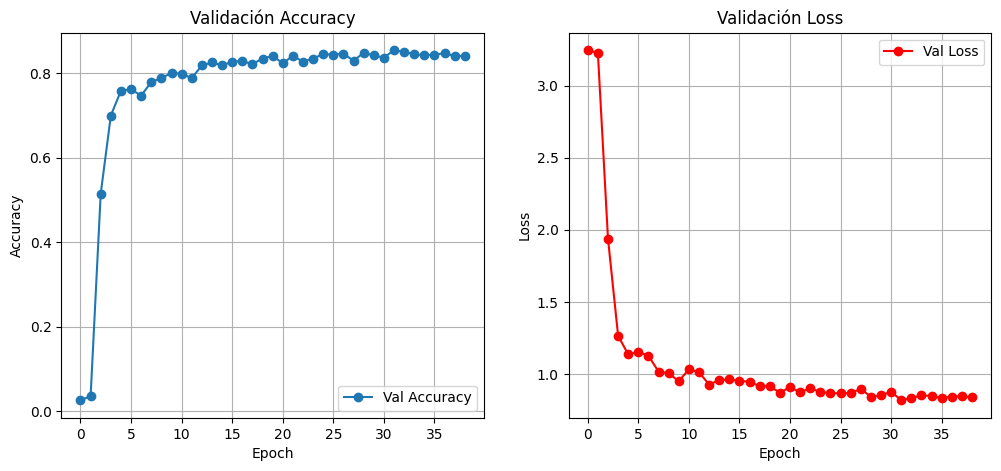

In [8]:
# ============================================================
# CURVAS DE LOSS Y ACCURACY
# ============================================================

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(val_accs, label="Val Accuracy", marker='o')
plt.title("Validación Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses, label="Val Loss", color='r', marker='o')
plt.title("Validación Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.show()

<Figure size 1600x1600 with 0 Axes>

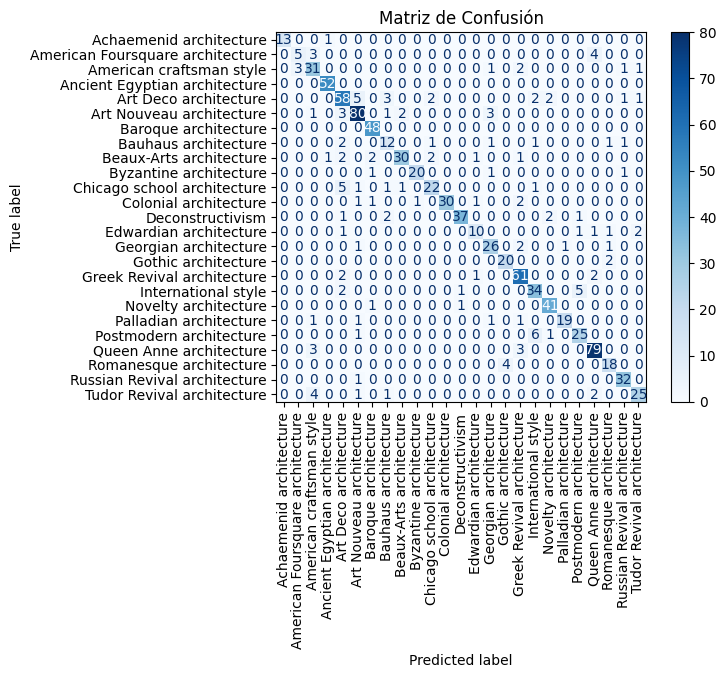

In [9]:
# ============================================================
# MATRIZ DE CONFUSIÓN
# ============================================================
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        _, predicted = preds.max(1)
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.classes)
plt.figure(figsize=(16,16))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Matriz de Confusión")
plt.show()

In [10]:
# ============================================================
# OBTENER PREDICCIONES DEL SET DE VALIDACIÓN
# ============================================================
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        preds = model(x)
        all_preds.append(preds.cpu())
        all_labels.append(y)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

y_pred = all_preds.argmax(dim=1).numpy()
y_true = all_labels.numpy()


In [11]:
print("\n=================== MÉTRICAS COMPLETAS ===================\n")

print("Accuracy top-1:", accuracy_score(y_true, y_pred))
print("Accuracy top-5:", top_k_accuracy_score(y_true, all_preds.numpy(), k=5))

target_names = val_ds.classes
print("\nCLASIFICATION REPORT:\n")
print(classification_report(y_true, y_pred, target_names=target_names))


=================== MÉTRICAS COMPLETAS ===================

Accuracy top-1: 0.8544891640866873
Accuracy top-5: 0.9731682146542827

CLASIFICATION REPORT:

                                  precision    recall  f1-score   support

         Achaemenid architecture       1.00      0.93      0.96        14
American Foursquare architecture       0.62      0.42      0.50        12
        American craftsman style       0.72      0.79      0.76        39
   Ancient Egyptian architecture       0.96      1.00      0.98        52
           Art Deco architecture       0.76      0.78      0.77        74
        Art Nouveau architecture       0.87      0.89      0.88        90
            Baroque architecture       0.91      1.00      0.95        48
            Bauhaus architecture       0.60      0.63      0.62        19
         Beaux-Arts architecture       0.91      0.77      0.83        39
          Byzantine architecture       0.95      0.87      0.91        23
     Chicago school architectu

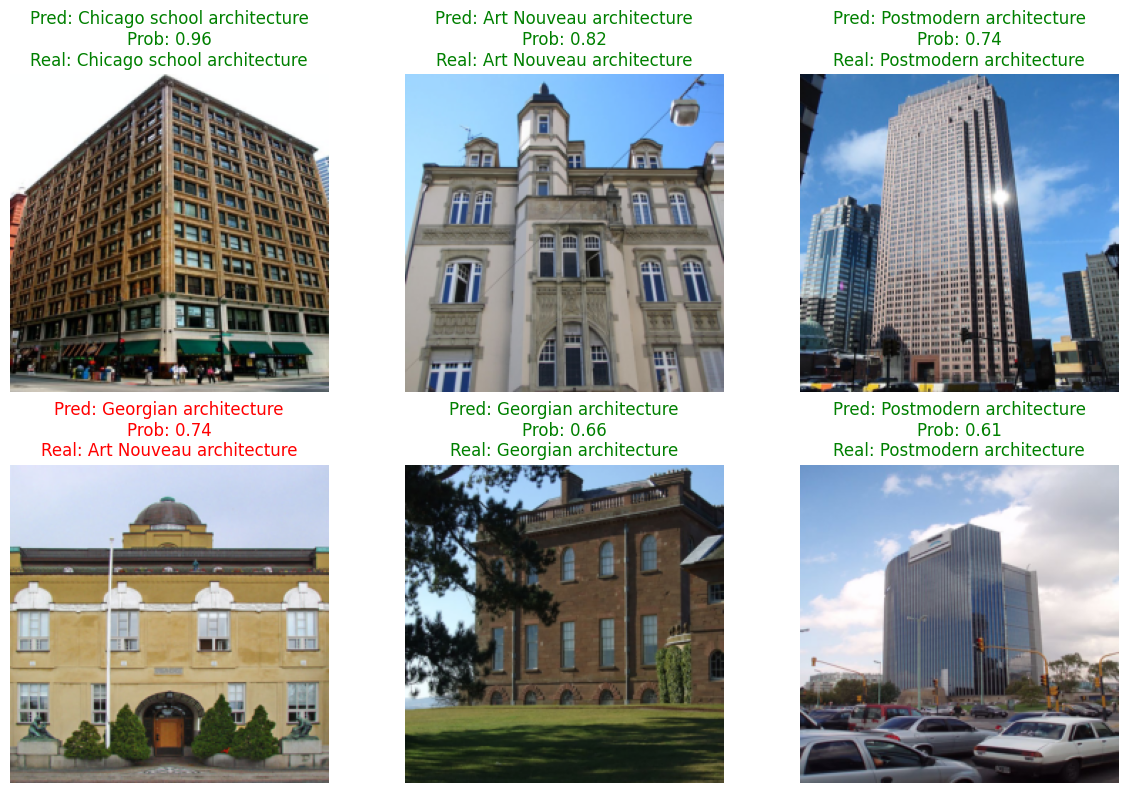

In [12]:
def show_predictions(model, dataset, num_images=6):
    model.eval()
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(DEVICE))
            prob = torch.softmax(pred, dim=1).cpu().numpy()[0]
            pred_class = prob.argmax()
            pred_prob = prob[pred_class]

        img_np = img.permute(1,2,0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, 3, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(
            f"Pred: {dataset.classes[pred_class]}\n"
            f"Prob: {pred_prob:.2f}\n"
            f"Real: {dataset.classes[label]}",
            color="green" if pred_class == label else "red"
        )

    plt.tight_layout()
    plt.show()

# Llamar:
show_predictions(model, val_ds, num_images=6)